# 简介

本次作业包含2个代码填空和2个Exercise。

回顾课堂内容，我们知道TRPO在很多场景上都很成功，但是我们也发现了它的计算过程非常的复杂，每步更新的运算量非常大。于是，在2017年TRPO的改进版PPO算法被提出，它基于TRPO的思想，但是实现算法更加简单，避免了复杂的求KL散度的Hessian矩阵。并且大量的实验结果表明，PPO能够比TRPO学习的更快，这使得PPO一下子成为了非常流行的强化学习算法。如果我们想要尝试在一个新的环境用强化学习，那么PPO就属于那种可以首先尝试的算法。

## PPO算法

我们回忆一下TRPO的优化目标：
$$
 \max\limits_{\theta}\mathbb{E}_{s\sim \nu^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[ \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s,a)\right]\quad\text{s.t.}\quad \mathbb{E}_{s\sim \nu^{\pi_{\theta_k}}}\left[D_{KL}(\pi_{\theta_k}(\cdot|s),\pi_\theta(\cdot|s))\right]\le\delta
$$

TRPO使用泰勒展开近似、共轭梯度、线性搜索等方法直接求解。PPO的优化目标同样是它，但PPO用了一些相对简单的方法来求解。具体来说，PPO有两种形式，一是PPO-Penalty，二是PPO-Clip。

### PPO-Penalty

PPO-Penalty用Lagrange乘子法直接将KL散度的限制放进了目标函数中，这就变成了一个无约束的优化问题，然后在迭代的过程中不断更新KL散度前的系数。即
$$
\theta=\mathop{\arg\max}_\theta \mathbb{E}_{s\sim \nu^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[ \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s,a)-\beta D_{KL}[\pi_{\theta_k}(\cdot|s),\pi_\theta(\cdot|s)]\right]
$$

令 $d_k=D_{KL}^{\nu^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_\theta)$，$\beta$ 的更新规则如下：
1. 如果$d_k<\delta/1.5$，那么$\beta_{k+1}\leftarrow \beta_k/2$
2. 如果$d_k>\delta\times1.5$，那么$\beta_{k+1}\leftarrow \beta_k\times 2$
3. 否则$\beta_{k+1}=\beta_k$。




### PPO-Clip

PPO-Clip更加直接，其直接在目标函数里进行限制，以保证新的参数和旧的参数的差距不会太大，即

$$
\theta=\mathop{\arg\max}_\theta \mathbb{E}_{s\sim \nu^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[\min \left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a),\text{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)},1-\epsilon,1+\epsilon\right)A^{\pi_{\theta_k}}(s,a)\right)\right]
$$

其中 $\text{clip}(x,l,r):=\max(\min(x,r),l)$ ，即把 $x$ 限制在 $[l,r]$ 内。上式中$\epsilon$是一个超参数，表示clip的范围。如果$A(s,a)>0$，说明这个动作的Q值高于平均，最大化这个式子会增大$\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过$1+\epsilon$。反之，如果$A(s,a)<0$，最大化这个式子会减小$\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过$1-\epsilon$。


# PPO代码实践

我们在两个环境CartPle和Pendulum上测试PPO算法。实验表明，PPO-Clip总是比PPO-Penalty表现得更好。因此下面我们只出PPO-Clip的代码。

### 环境1

首先导入一些必要的库。

In [1]:
%pip install gym
import torch
import torch.utils.data
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output

Note: you may need to restart the kernel to use updated packages.


我们的PPOAgent主要有两个网络：policy网络和value网络。

In [2]:
class PPOAgent:
  
  """创建两种agent，并设定部分超参数。"""
  def __init__(self, feature_n, action_n):

    self.policy_model = torch.nn.Sequential(torch.nn.Linear(feature_n, 30),
                         torch.nn.Tanh(),
                         torch.nn.Linear(30, action_n),
                         torch.nn.Softmax(dim=1))
    self.value_model = torch.nn.Sequential(torch.nn.Linear(feature_n, 30),
                         torch.nn.ReLU(),
                         torch.nn.Linear(30, 10),
                         torch.nn.ReLU(),
                         torch.nn.Linear(10, 1))

    self.policy_optim = torch.optim.Adam(self.policy_model.parameters(), lr=1e-4)
    self.value_optim = torch.optim.Adam(self.value_model.parameters(), lr=3e-4)

    self.gamma = 0.98 # 折扣因子
    self.batch_size = 128
    self.eps = 0.2
  
  """根据给定的状态，采样动作。"""
  def sample_action(self, state):
    state_tensor = torch.tensor(state, dtype=torch.float)
    prob = self.policy_model(state_tensor)
    dist = torch.distributions.Categorical(probs=prob)
    return dist.sample(), prob
  
  """根据给定的状态，计算V函数。"""
  def get_value(self, state):
    return self.value_model(state)

  """策略学习。"""
  def policy_learn(self, s, a, old_pro, adv):
    ########################################
    ## Programming 1:策略更新
    ########################################
    # # prob_ratio = torch.zeros(1)
    new_log_prob = torch.log(self.policy_model(s).gather(1, a))
    old_log_prob = torch.log(old_pro.gather(1, a)).detach()
    prob_ratio = torch.exp(new_log_prob - old_log_prob)
    loss = torch.mean(-torch.min(prob_ratio * adv, torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps) * adv))

    self.policy_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), .5)
    self.policy_optim.step()
    #############################
    ########################################
    ## End of Programming 1
    ########################################
    return prob_ratio  # 返回probability ratio以观察训练过程

  """价值学习。"""
  def value_learn(self, s, r, d, s_):
    v_ = self.get_value(s_)
    v = self.get_value(s)
    td_error = v - (r + (1-d) * self.gamma * v_).detach()
    loss = td_error.pow(2).mean()

    self.value_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), .5)
    self.value_optim.step()

计算advantage函数的时候，对于Q函数的计算做一步展开（TD）。

In [3]:
def compute_advantage(s, s_, r, d, agent):
  with torch.no_grad():
    q_fn = r + (1-d) * agent.gamma * agent.value_model(s_)
  return q_fn - agent.value_model(s)

创建环境，并设定随机数种子以便重复实现。

In [4]:
env_name = "CartPole-v1"
env = gym.make(env_name)

seed = 999
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)

实例化agent并开始训练。在训练过程中，我们会动态描绘训练曲线（横坐标是episode，纵坐标是对应的reward）。

当训练出的agent已经足够好时，训练停止并输出“Solved!”。

期望运行时间：$1$分钟。

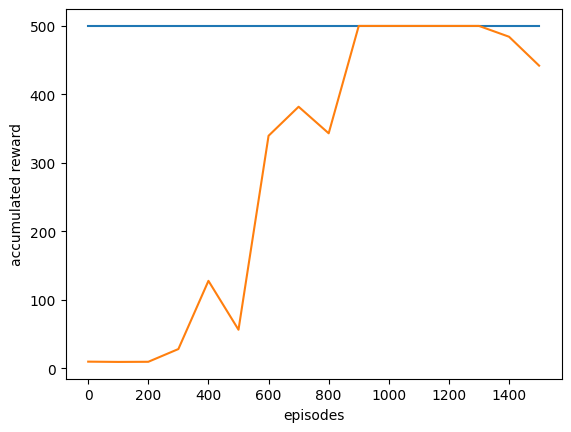

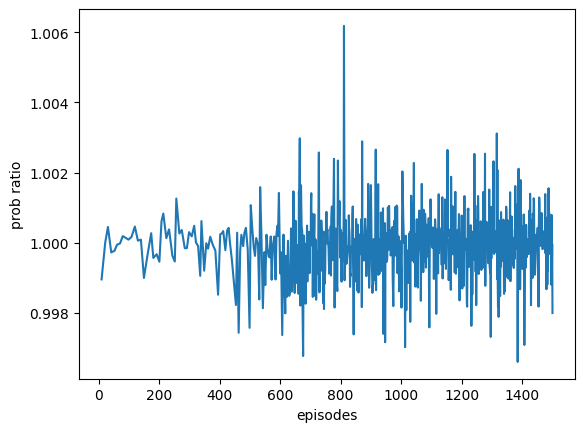

In [5]:
# line = 200
line = 500
agent = PPOAgent(env.observation_space.shape[0], env.action_space.n)
epi_n = 1500
mini_epoch = 15
i_list = []
r_list = []
p_list = []
p_i_list = []

s, a, p, r, s_, d = [], [], [], [], [], []

for i in range(epi_n + 1):
  state = env.reset()[0]
  done = False
  
  tot_reward = 0
  while not done:
    action, action_distribution = agent.sample_action([state])
    next_state, reward, terminated, truncated, info = env.step(action.item())
    done = terminated or truncated
    tot_reward += reward

    if done: 
      reward = -20

    s.append(state) 
    a.append(action) 
    p.append(action_distribution) 
    r.append(reward) 
    s_.append(next_state) 
    d.append(done)

    state = next_state
  
  if len(s) >= 200:
    # print(f"collect {len(s)} samples")
    s = torch.tensor(s, dtype = torch.float)
    a = torch.tensor(a, dtype = torch.long).view(-1, 1)
    p = torch.cat(p).view(-1, 2)
    r = torch.tensor(r, dtype = torch.float).view(-1, 1)
    s_ = torch.tensor(s_, dtype = torch.float)
    d = torch.tensor(d, dtype = torch.float).view(-1, 1)

    adv = compute_advantage(s, s_, r, d, agent).detach().view(-1, 1)

    prob_ratio = 0
    for _ in range(mini_epoch):
      prob_list = []
      for idx in torch.utils.data.sampler.BatchSampler(
          torch.utils.data.sampler.SubsetRandomSampler(range(len(s))), agent.batch_size, False):
        prob = agent.policy_learn(s[idx], a[idx], p[idx], adv[idx])
        agent.value_learn(s[idx], r[idx], d[idx], s_[idx])
        prob_list.append(prob.mean().item())
      prob_ratio += np.mean(prob_list)
    p_list.append(prob_ratio / mini_epoch)
    p_i_list.append(i)
    # on-policy 训练
    s, a, p, r, s_, d = [], [], [], [], [], []

  # 画图

  if i % 100 == 0:
    plt.figure()
    plt.plot([0, i], [line, line])
    i_list.append(i)
    tot_reward_list = []
    for _ in range(5):
      tot_reward = 0
      state = env.reset()[0]
      done = False
      while not done:
        _, prob = agent.sample_action([state])
        action = prob.argmax(-1)
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        tot_reward += reward
      tot_reward_list.append(tot_reward)
    r_list.append(np.mean(tot_reward_list))
    plt.plot(i_list, r_list)
    clear_output(True)
    plt.xlabel('episodes')
    plt.ylabel('accumulated reward')
    plt.figure()
    plt.plot(p_i_list, p_list)
    plt.xlabel('episodes')
    plt.ylabel('prob ratio')
    plt.show()

参考训练过程如下：

![Image Name](https://cdn.kesci.com/upload/rt/w39tuKE-Rwv_/qsxj2k8ece.png)



![Image Name](https://cdn.kesci.com/upload/rt/w39tuKE-Rwv_/qsxj2kvekg.png)


在上面的图中，probability ratio的值可以用来作为mini-epoch，learning rate这些参数调节的依据。离散动作空间中，在训练中期，该值可以说明策略更新的幅度，且应该保持在较大的值。而在下面的连续动作空间中，由于假设习得的动作分布是高斯分布，该值一般较为稳定。

### 连续动作环境

对于连续动作环境，我们需要对上面的代码做一定的修改。具体来说，需要修改以下代码块（直接运行即可）。

下面是新的policy网络，因为环境是连续动作的，因此我们的网络分别输出表示动作分布的高斯分布的 $\mu$ 和 $\sigma$ 。

In [6]:
class PolicyModel(torch.nn.Module):
  def __init__(self, feature_n):
    super(PolicyModel, self).__init__()
    self.l1 = torch.nn.Linear(feature_n, 100)
    self.l2 = torch.nn.Linear(100, 1)
    self.l3 = torch.nn.Linear(100, 1)
  def forward(self, x):
    x = torch.nn.functional.relu(self.l1(x))
    mu = 2 * torch.tanh(self.l2(x))
    sigma = torch.nn.functional.softplus(self.l3(x))
    return mu, sigma

以及修改一些主函数。

这和上面的PPOAgent是类似的，只有部分修改。

In [7]:
class PPOAgent:
  
  def __init__(self, feature_n, action_n):

    self.policy_model = PolicyModel(feature_n)
    self.value_model = torch.nn.Sequential(torch.nn.Linear(feature_n, 100),
                         torch.nn.ReLU(),
                         torch.nn.Linear(100, 1))

    self.policy_optim = torch.optim.Adam(self.policy_model.parameters(), lr=1e-4)
    self.value_optim = torch.optim.Adam(self.value_model.parameters(), lr=3e-4)

    self.gamma = 0.9 # 折扣因子
    self.batch_size = 128
    self.eps = 0.2
  
  def sample_action(self, state):
    state_tensor = torch.tensor(state, dtype=torch.float)
    with torch.no_grad():
      mu, sigma = self.policy_model(state_tensor)
    dist = torch.distributions.normal.Normal(mu, sigma)
    action = dist.sample()
    action_log_prob = dist.log_prob(action)
    return action.item(), action_log_prob.item(), dist
  
  def get_value(self, state):
    return self.value_model(state)

  def policy_learn(self, s, a, old_p, adv):
    ########################################
    ## Programming 2:策略更新
    ########################################
    # prob_ratio = torch.zeros(1)
    mu, sigma = self.policy_model(s)
    dist = torch.distributions.normal.Normal(mu, sigma)
    new_log_prob = dist.log_prob(a)
    old_log_prob = old_p.detach()
    prob_ratio = torch.exp(new_log_prob - old_log_prob)
    loss = torch.mean(-torch.min(prob_ratio * adv, torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps) * adv))

    self.policy_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), .5)
    self.policy_optim.step()
    ########################################
    ## End of Programming 2
    ########################################
    return prob_ratio

  def value_learn(self, s, r, d, s_):
    v_ = self.get_value(s_)
    v = self.get_value(s)
    td_error = v - (r + (1-d) * self.gamma * v_).detach()
    loss = td_error.pow(2).mean()

    self.value_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), .5)
    self.value_optim.step()


创建环境Pendulum-v1，并设定随机数种子以便重复实现。

In [8]:
env_name = "Pendulum-v1"
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)

实例化agent并开始训练。在训练过程中，我们会动态描绘训练曲线（横坐标是episode，纵坐标是对应的reward）。

当训练出的agent已经足够好时，训练停止并输出“Solved!”。

期望运行时间：$3$分钟。

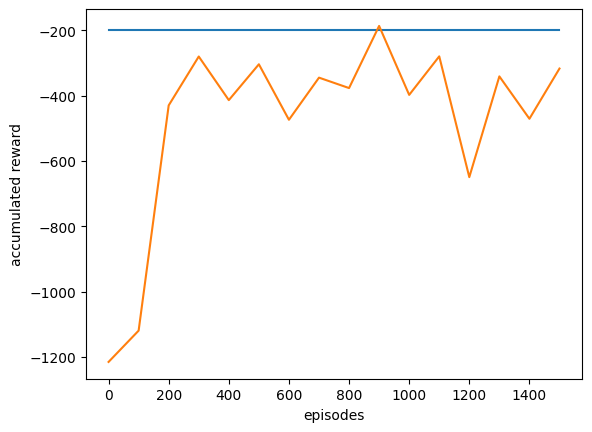

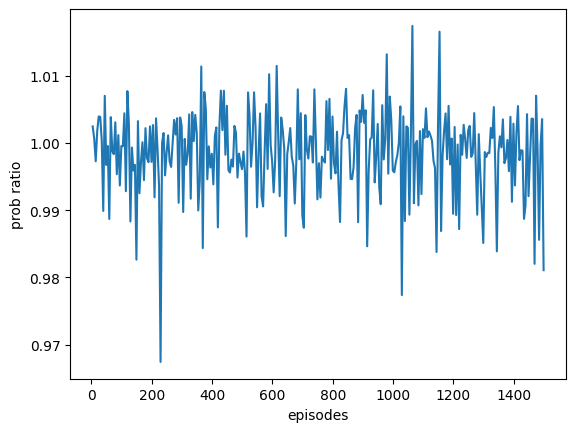

In [9]:
line = -200

agent = PPOAgent(env.observation_space.shape[0], env.action_space.shape[0])
epi_n = 1500
mini_epoch = 15
i_list = []
r_list = []
p_list = []
p_i_list = []
s, a, p, r, s_, d = [], [], [], [], [], []

for i in range(epi_n + 1):
  state = env.reset()[0]
  done = False
  
  tot_reward = 0
  while not done:
    action, action_distribution,_ = agent.sample_action([state])
    next_state, reward, terminated, truncated, info = env.step([action])
    done = terminated or truncated
    tot_reward += reward

    s.append(state) 
    a.append(action) 
    p.append(action_distribution) 
    r.append(reward) 
    s_.append(next_state) 
    d.append(done)

    state = next_state

  if len(s) >= 1000:
    s = torch.tensor(s, dtype = torch.float)
    a = torch.tensor(a, dtype = torch.float).view(-1, 1)
    p = torch.tensor(p, dtype = torch.float).view(-1, 1)
    r = torch.tensor(r, dtype = torch.float).view(-1, 1)
    s_ = torch.tensor(s_, dtype = torch.float)
    d = torch.tensor(d, dtype = torch.float).view(-1, 1)

    r = (r - r.mean()) / (r.std() + 1e-8)

    adv = compute_advantage(s, s_, r, d, agent).detach().view(-1, 1)

    prob_ratio = 0
    for _ in range(mini_epoch):
      prob_list = []
      for idx in torch.utils.data.sampler.BatchSampler(
          torch.utils.data.sampler.SubsetRandomSampler(range(len(s))), agent.batch_size, False):
        prob = agent.policy_learn(s[idx], a[idx], p[idx], adv[idx])
        agent.value_learn(s[idx], r[idx], d[idx], s_[idx])
        prob_list.append(prob.mean().item())
      prob_ratio += np.mean(prob_list)
    p_list.append(prob_ratio / mini_epoch)
    p_i_list.append(i)
    # on-policy 训练
    s, a, p, r, s_, d = [], [], [], [], [], []

  # 画图
  if i % 100 == 0:
    plt.figure()
    plt.plot([0, i], [line, line])
    i_list.append(i)
    tot_reward_list = []
    for _ in range(5):
      tot_reward = 0
      state = env.reset()[0]
      done = False
      while not done:
        _, _, prob = agent.sample_action([state])
        action = prob.mean
        state, reward, terminated, truncated, _ = env.step([action.item()])
        done = terminated or truncated
        tot_reward += reward
      tot_reward_list.append(tot_reward)
    r_list.append(np.mean(tot_reward_list))
    plt.plot(i_list, r_list)
    clear_output(True)
    plt.xlabel('episodes')
    plt.ylabel('accumulated reward')
    plt.figure()
    plt.plot(p_i_list, p_list)
    plt.xlabel('episodes')
    plt.ylabel('prob ratio')
    plt.show()

参考训练过程如下：

![Image Name](images/1.png)

![Image Name](images/2.png)



# 更新目标理论
学习完这两章，现在我们给出一些关于策略梯度算法的更新目标的理论：
首先，由策略梯度定理（证明见策略梯度章节的作业），我们知道：
$$
\nabla_{\theta} \mathbb{E}_{\tau \sim \pi_{\theta}}[R(\tau)] = 
\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1} \nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\left(\sum_{t^{\prime}=t}^{T-1} r_{t^{\prime}}\right)\right] 
\tag{1}
$$
对比PPO的更新目标（这里使用GAE($\lambda,0)$）$\mathbb{E}_{s_t,s_{t+1} \sim \pi_{\theta}}[r_t+\gamma V(s_{t+1})-V(s_{t})]$和公式(1)，发现其中的差异主要在于减去了一项$V(s_{t})$，这一项通常被称为Baseline，此项一般只与状态有关。

将Baseline表示为$b(s_t)$，引入Baseline，有
$$
\nabla_{\theta} \mathbb{E}_{\tau \sim \pi_{\theta}}[R(\tau)] = 
\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1} \nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\left(\sum_{t^{\prime}=t}^{T-1} r_{t^{\prime}}-b(s_t)\right)\right] 
\tag{2}
$$


**Exercise 1**. 证明
$$
\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right)\right] = 0 \tag{3}.
$$

提示1：$\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right)\right]=\mathbb{E}_{s_{0: t}, a_{0: t-1}}\left[\mathbb{E}_{s_{t+1: T}, a_{t: T-1}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right)\right]\right]$.

提示2：要**证明** $\mathbb{E}_{a_{t}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\right]=0$.

**证明**：

首先证明提示2：

由于$\pi_{\theta}(a_t|s_t)$是概率分布，则有：
$$
\sum_{a_t} \pi_{\theta}(a_t|s_t) = 1,
$$
根据对数概率的定义，即可得到提示2的式子：
$$
\mathbb{E}_{a_t} \left[\nabla_{\theta} \log \pi_{\theta}(a_t|s_t)\right] = \mathbb{E}_{a_t} \left[\frac{\nabla_{\theta} \pi_{\theta}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right] = \sum_{a_t} \frac{\nabla_{\theta} \pi_{\theta}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)} \pi_{\theta}(a_t|s_t) = \sum_{a_t} \nabla_{\theta} \pi_{\theta}(a_t|s_t) = \nabla_{\theta} \sum_{a_t} \pi_{\theta}(a_t|s_t) = \nabla_{\theta} 1 = 0.
$$

根据提示1和$b\left(s_{t}\right)$只与状态有关，有：

$$
\begin{aligned}
&\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right)\right]\\
=& \mathbb{E}_{s_{0: t}, a_{0: t-1}}\left[\mathbb{E}_{s_{t+1: T}, a_{t: T-1}}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right)\right]\right] \\
=& \mathbb{E}_{s_{0: t}, a_{0: t-1}}\left[\mathbb{E}_{a_{t} \sim \pi_{\theta}\left(\cdot \mid s_{t}\right)}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) b\left(s_{t}\right) \right]\right] \\
=& \mathbb{E}_{s_{0: t}, a_{0: t-1}}\left[b\left(s_{t}\right) \mathbb{E}_{a_{t} \sim \pi_{\theta}\left(\cdot \mid s_{t}\right)}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\right]\right] \\
=& \mathbb{E}_{s_{0: t}, a_{0: t-1}}\left[b\left(s_{t}\right) \cdot 0\right] \\
=& 0.
\end{aligned}
$$

证毕。

**Exercise 2**.
证明
1. 求出最小化$Var(\widehat{\nabla_{\theta} J})$的$b^{*}(s^{k}_t)$, 并指出其在何种条件下等于$\mathbb{E}_{\tau}\left[\sum_{t^{\prime}=t}^{T-1} r^{k}_{t^{\prime}}(s_{t^{\prime}}^k, a_{t^{\prime}}^k)\right]=V(s^k_t)$.
2. 记不用Baseline的梯度估计为
$$
\widehat{\nabla_{\theta} J}^{\prime} = \frac{1}{N}\sum_{k=0}^{N} \left[\sum_{t=0}^{T-1} \nabla_{\theta} \log \pi_{\theta}\left(a_{t}^{k} \mid s_{t}^{k}\right)\left(\sum_{t^{\prime}=t}^{T-1} r^{k}_{t^{\prime}}\right)\right]. \tag{5}
$$
证明使用$b^{*}$的梯度估计方差小于该不用baseline的梯度估计方差。

提示1：$Var(X)=\mathbb{E}(X^2)-(\mathbb{E}(X))^2$, $Var(X+Y) = Var(X)+Var(Y)+2Cov(X,Y)$

提示2：使用**Ex 1**的结论。

提示3： 最小二乘法。

**证明**：
 
1. 
为了方便，设$\tau$为一条轨迹，把$\sum_{t^{\prime}=t}^{T-1} r^{k}_{t^{\prime}}(s_{t^{\prime}}^k, a_{t^{\prime}}^k)$简写为$r_t(\tau)$，$\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)$简写为$g(\tau)$。则有：
$$
\widehat{\nabla_{\theta} J}
= \frac{1}{N}\sum_{k=0}^{N} \left[\sum_{t=0}^{T-1} \nabla_{\theta} \log \pi_{\theta}\left(a_{t}^{k} \mid s_{t}^{k}\right)\left(\sum_{t^{\prime}=t}^{T-1} r^{k}_{t^{\prime}} - b\left(s_{t}\right)\right)\right]
= \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1}g(\tau) \left(r_t(\tau) - b\left(s_{t}\right)\right)\right],
$$
$$
Var(\widehat{\nabla_{\theta} J})
= \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\left(\sum_{t=0}^{T-1}g(\tau) \left(r_t(\tau) - b\left(s_{t}\right)\right)\right)^2\right] - \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1}g(\tau) \left(r_t(\tau) - b\left(s_{t}\right)\right)\right]^2.
$$

由Ex1知，
$$
\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1}g(\tau)\left(r_t(\tau) - b\left(s_{t}\right)\right)\right]
=\mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1}g(\tau)r_t(\tau)\right].
$$
因此上式的第二项与$b(s_t)$无关，要使$Var(\widehat{\nabla_{\theta} J})$最小，只需
$$
\frac{d Var(\widehat{\nabla_{\theta} J})}{d b} 
= \frac{d \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\left(\sum_{t=0}^{T-1}g(\tau) \left(r_t(\tau) - b\left(s_{t}\right)\right)\right)^2\right]}{d b} 
=0.
$$
通过最小二乘法，可以解得：
$$
b^{*}(s^{k}_t)=\mathbb{E}_{\tau}\left[\sum_{t^{\prime}=t}^{T-1} r^{k}_{t^{\prime}}(s_{t^{\prime}}^k, a_{t^{\prime}}^k)\right].
$$
给定策略$\pi$，当$V(s^k_t)$表示在策略$\pi$下，从$t$时刻、状态$s^k_t$开始的未来奖励之和的期望时，有$b^{*}(s^{k}_t)=V(s^k_t)$.


2.
$$
Var(\widehat{\nabla_{\theta} J'})
= \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\left(\sum_{t=0}^{T-1}g(\tau) r_t(\tau) \right)^2\right] - \mathbb{E}_{\tau \sim \pi_{\theta}}\left[\sum_{t=0}^{T-1}g(\tau) r_t(\tau) \right]^2.
$$
两个variance都是A-B的形式，设$Var(\widehat{\nabla_{\theta} J})=A-B,Var(\widehat{\nabla_{\theta} J'})=A'-B'$，取$b^*$的是$Var(\widehat{\nabla_{\theta} J^*})=A^*-B^*$。

由Ex1知，$B=B'=B^*$；对于前一项，$A^*$是$A$的最小值，$A'$可以看作是取$b=0$的$A$，所以$A^*-B^*<A'-B'$，即使用$b^{*}$的梯度估计方差小于该不用baseline的梯度估计方差。